####  iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋: iris.csv-> feature 3
- 구현 프레임워크: Pytorch


[1] 모듈 로딩 및 데이터 준비

In [99]:
# 모듈 로딩
import torch                                                         #텐서 및 수치 계산 모듈
import torch.nn as nn                                                #인공신경망
import torch.nn.functional as F                                      #손실, 거리 계산 모듈
import torch.optim as optimizer                                      # 최적화 기법 모듈
import pandas as pd
from torchmetrics.regression import R2Score
from sklearn.model_selection import train_test_split
from torchinfo import summary                                        #모델 정보 관련 모듈


In [100]:
# 데이터 로딩
File='../data/iris.csv'
irisDF=pd.read_csv(File, usecols=[0,1,2,3])
irisDF.head()

torch.manual_seed(1)

DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE= {DEVICE}')

DEVICE= cpu


[2] 모델 준비
- 학습 방법: 지도학습(회귀)
- 알고리즘: 선형관계 >> 선형모델 ==>nn.linear
+ 입력받는 값= 전 단계에 존재하는 퍼셉트론 개수

In [101]:
# 모델 설계
# 입력층에 입력값 : petal.length, sepal.length, sepal.width 3개
# 출력층에 입력값 : petal.width 1개
# 입력층: 입력 피쳐3, 출력 입력층에 존재하는 퍼셉트론 개수 10, AF(activation function) ReLU
# 은닉층: 입력 10개(=입력층에서 받은 퍼셉트론 개수), 출력 은닉층에 존재하는 퍼셉트론 개수 5, AF ReLU
# 출력층: 입력 5개(=은닉층에서 받은 퍼셉트론 개수), 출력 타겟/라벨 수 1, (AF Sigmoid??)

model=nn.Sequential(nn.Linear(3,10),
                    nn.ReLU(),
                    nn.Linear(10,5),
                    nn.ReLU(),
                    nn.Linear(5,1))

In [102]:
# 모델 구조 확인
print(model)
# 파라미터 수= 퍼셉트론 수 *(피쳐수+절편)
summary(model, input_size=(3,))

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [10]                      40
├─ReLU: 1-2                              [10]                      --
├─Linear: 1-3                            [5]                       55
├─ReLU: 1-4                              [5]                       --
├─Linear: 1-5                            [1]                       6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [103]:
for name, param in model.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)
0.bias Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)
2.weight Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038,  0.0695,  

[3] 최적화 인스턴스 준비


In [104]:
# 모델의 가중치와 절편을 최적화-> 인스턴스에 전달
adam_optim= optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습-> 개발자가 구현

[4-1] 데이터셋 Tensor화 진행: 데이터준비시 진행 or 학습 전 진행

In [105]:
# 피쳐와 타겟을 분리
featureDF=irisDF[['sepal.length', 'sepal.width', 'petal.length']]
targetDF=irisDF[['petal.width']]
print(featureDF.shape)
targetDF.shape

(150, 3)


(150, 1)

In [106]:
X_train, X_test, Y_train, Y_test= train_test_split(featureDF,targetDF, test_size=.2)
X_train, X_val, Y_train, Y_val= train_test_split(X_train, Y_train, test_size=.2)

print(f'train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}')
print(f'train: {Y_train.shape}, val: {Y_val.shape}, test: {Y_test.shape}')

train: (96, 3), val: (24, 3), test: (30, 3)
train: (96, 1), val: (24, 1), test: (30, 1)


- [4-2] 학습 진행
    - 학습횟수 결정 ==> 에포크 설정
    - 배치 크기 결정
    - 배치개수 계산

In [107]:
EPOCH=1000                                      # 처음부터 끝까지 학습하는 횟수
BATCH_SIZE=12                                   # 1에포크에서 한번 학습할 분량 크기
BATCH_CNT= X_train.shape[0]//BATCH_SIZE         # 1에포크에서 총 학습 횟수 =가중치 업데이트 횟수
# 나머지가 있을 경우 
# - 다시 0부터 끌어와서 학습시킴-> Batch_CNT-> +1=> ??
# - 버림 -> 나중에 검증 데이터로 활용           =>선택
print(EPOCH, BATCH_SIZE, BATCH_CNT)

1000 12 8


In [108]:
# 테스트/검증 함수
# 가중치 업데이트X, 최적화 미진행
# 현재 가중치와 절편값으로 테스트 진행
def testing(model, X_val, Y_val, kind='Val'):
    # tensor화
    bsX_val= torch.FloatTensor(X_val.values).to(DEVICE)
    bsY_val= torch.FloatTensor(Y_val.values).to(DEVICE)

    with torch.no_grad():   #가중치 및 절편 업데이트 진행 X
        # (1) 학습진행  forward(순전파)
        # - 먼저 shape과 dtype이 동일한지 확인을 위해 실행해보기!!
        pre_y= model(bsX_val)

        # (2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y, bsY_val)
        
        # (3) 성능평가 - r2
        r2=R2Score()(pre_y, bsY_val)
         
        # (5) 학습결과 출력 및 저장
        print(f'[{kind}] LOSS: {loss}, R2: {r2}')
        return loss, r2

In [109]:
# 모델 학습 함수


def training(X_train, Y_train, X_val, Y_val):
    EPOCH=100
    BATCH_SIZE=12
    BATCH_CNT= X_train.shape[0]//BATCH_SIZE
                # T   V
    loss_history=[[],[]]
    r2_history= [[],[]]
    for epch in range(1,EPOCH+1):
        # 배치 손실 저장 변수
        bs_loss, bs_r2=0,0
        # 배치 크기 만큼 학습
        for i in range(BATCH_CNT):
            start= i*BATCH_SIZE
            end= start+ BATCH_SIZE
            print(start, end)
            # BS크기 만큼만 데이터 추출해서 Tensor화 진행
            BSX_train= torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            BSY_train= torch.FloatTensor(Y_train[start:end].values).to(DEVICE)
            print(BSX_train.shape, BSX_train.device, BSX_train.dtype)
            print(BSY_train.shape, BSY_train.device, BSY_train.dtype)


            pre_y= model(BSX_train)
            print(pre_y.shape)

            # (2) 오차계산 - 손실함수
            loss=F.mse_loss(pre_y, BSY_train)
            bs_loss+= loss.item()
            bs_r2 +=R2Score()(pre_y, BSY_train).item()

            # (3) 최적화 - 가중치, 절편 업데이트 backward(역전파)
            # - 가중치 초기화 -> 가중치 계산 -> 가중치 적용
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()

        # (4)검증
        val_loss, val_r2=testing(model, X_val, Y_val)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())

        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)
        # (5) 학습결과 출력 및 저장
        print(f'[{epch}/{EPOCH}] \nTrain => LOSS: {loss_history[0][-1]}\nR2: {r2_history[0][-1]}')
        print(f'VAL => LOSS: {loss_history[1][-1]}\nR2: {r2_history[1][-1]}')
    return loss_history, r2_history

In [110]:
loss, r2= training(X_train, Y_train, X_val, Y_val)

0 12
torch.Size([12, 3]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
12 24
torch.Size([12, 3]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
24 36
torch.Size([12, 3]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
36 48
torch.Size([12, 3]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
48 60
torch.Size([12, 3]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
60 72
torch.Size([12, 3]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
72 84
torch.Size([12, 3]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
84 96
torch.Size([12, 3]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
[Val] LOSS: 0.43133535981178284, R2: 0.07570922374725342
[1/100] 
Train => LOSS: 0.8913326971232891
R2: -0.8331936821341515
VAL => LOSS: 0.43133535981178284
R2: 0.07570922374725342
0 12

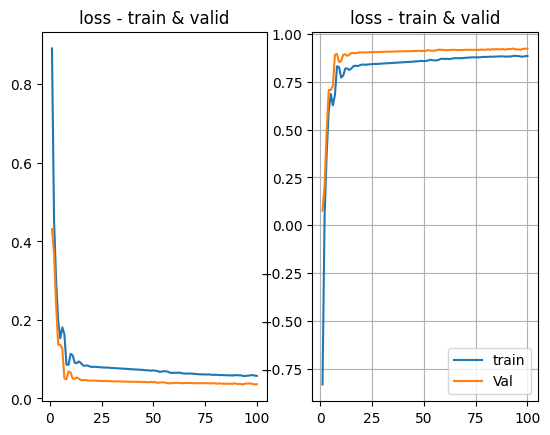

In [111]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

TRESHOLD=100
fg, axes=plt.subplots(1,2)
axes[0].plot(range(1,TRESHOLD+1), loss[0], label='train')
axes[0].plot(range(1,TRESHOLD+1), loss[1], label='Val')
axes[0].set_title('loss - train & valid')

axes[1].plot(range(1,TRESHOLD+1), r2[0], label='train')
axes[1].plot(range(1,TRESHOLD+1), r2[1], label='Val')
axes[1].set_title('loss - train & valid')
plt.grid()
plt.legend()
plt.show()